<a href="https://colab.research.google.com/github/usintec/3DBEFUnet/blob/master/3DBEFUnet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# =========================
# Setup Kaggle & Download BraTS2020 Dataset
# =========================

# Install required libraries
!pip install -q nibabel pydicom nilearn matplotlib opencv-python kaggle

import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
import scipy.ndimage as ndimage



In [2]:

# =========================
# 1. Kaggle API Setup
# =========================
# Upload kaggle.json from your Kaggle account to Colab
from google.colab import files

print("Please upload your kaggle.json (from Kaggle > Account > Create API Token)")
files.upload()

# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# =========================
# 2. Download BraTS2020 Dataset
# =========================
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content/

# Unzip dataset
!unzip -q /content/brats20-dataset-training-validation.zip -d /content/brats2020



Please upload your kaggle.json (from Kaggle > Account > Create API Token)


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [02:06<00:00, 15.3MB/s]
100% 4.16G/4.16G [02:06<00:00, 35.2MB/s]


In [4]:
# Check dataset structure
!ls /content/brats2020

# =========================
# 3. Load & Explore MRI Data
# =========================
# Example: Load one subject
example_path = glob.glob("/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/*.nii*")[0]
print("Example file:", example_path)

# Load NIfTI image using nibabel
img = nib.load(example_path)
img_data = img.get_fdata()

print("Image shape:", img_data.shape)  # typically (240, 240, 155)



BraTS2020_TrainingData	BraTS2020_ValidationData
Example file: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii
Image shape: (240, 240, 155)


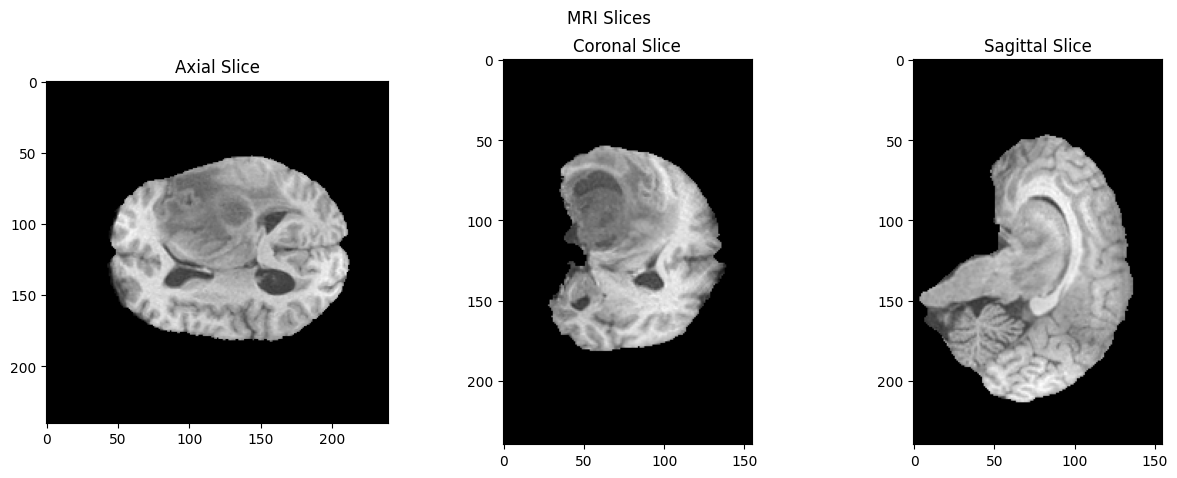

In [5]:
# =========================
# 4. Visualize MRI slices
# =========================
def plot_slices(img_data, title="MRI Slices"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_data[:, :, img_data.shape[2]//2], cmap="gray")
    axes[0].set_title("Axial Slice")
    axes[1].imshow(img_data[:, img_data.shape[1]//2, :], cmap="gray")
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(img_data[img_data.shape[0]//2, :, :], cmap="gray")
    axes[2].set_title("Sagittal Slice")
    plt.suptitle(title)
    plt.show()

plot_slices(img_data)



In [33]:
import matplotlib.pyplot as plt

def plot_mri_modalities(modalities, slice_idx=None, modality_names=None):
    """
    Plot MRI slices for different modalities.

    Args:
        modalities (torch.Tensor or np.ndarray): Shape (4, H, W, D)
        slice_idx (int): Index of the slice along the axial plane (D). If None, uses the middle slice.
        modality_names (list): List of modality labels, e.g. ["T1", "T1ce", "T2", "FLAIR"]
    """
    if isinstance(modalities, torch.Tensor):
        modalities = modalities.numpy()

    if modalities.shape[0] != 4:
        raise ValueError(f"Expected 4 modalities, got {modalities.shape[0]}")

    if slice_idx is None:
        slice_idx = modalities.shape[-1] // 2  # middle slice

    if modality_names is None:
        modality_names = ["T1", "T1ce", "T2", "FLAIR"]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        axes[i].imshow(modalities[i, :, :, slice_idx], cmap="gray")
        axes[i].set_title(modality_names[i])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


In [22]:
# =========================
# Preprocessing Utilities
# =========================
def normalize(volume):
    """Normalize volume to [0,1]."""
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val == 0:
        return np.zeros(volume.shape)
    volume = (volume - min_val) / (max_val - min_val)
    return volume.astype(np.float32)



In [23]:
def resize_volume(img, target_shape=(128, 128, 128)):
    """Resize 3D volume with scipy ndimage zoom."""
    factors = (
        target_shape[0] / img.shape[0],
        target_shape[1] / img.shape[1],
        target_shape[2] / img.shape[2],
    )
    img = ndimage.zoom(img, factors, order=1)  # linear interpolation
    return img


In [24]:

# =========================
# Data Augmentation
# =========================
def augment(modalities, seg):
    """Random flip, rotation, and noise."""
    # Random flip
    if random.random() > 0.5:
        modalities = np.flip(modalities, axis=2).copy()  # flip W axis
        seg = np.flip(seg, axis=1).copy()

    # Random rotation (±15° around z-axis)
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        for i in range(modalities.shape[0]):
            modalities[i] = ndimage.rotate(modalities[i], angle, axes=(0, 1), reshape=False, order=1)
        seg = ndimage.rotate(seg, angle, axes=(0, 1), reshape=False, order=0)

    # Random Gaussian noise
    if random.random() > 0.5:
        noise = np.random.normal(0, 0.01, modalities.shape)
        modalities = modalities + noise

    return modalities, seg

In [27]:
# =========================
# 5. Data Loader Preparation (for BEFUnet)
# =========================
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=True, target_shape=(128,128,128)):
        """
        Args:
            data_dir (str): Path to BraTS2020 training folder
            transform (bool): Whether to apply augmentation
            target_shape (tuple): Shape to resize volumes
        """
        self.case_dirs = sorted(glob.glob(os.path.join(data_dir, "BraTS20_Training_*")))
        self.transform = transform
        self.target_shape = target_shape

        print(f"Found {len(self.case_dirs)} cases in {data_dir}")

    def __len__(self):
        return len(self.case_dirs)

    def __getitem__(self, idx):
        case_dir = self.case_dirs[idx]
        files = sorted(glob.glob(os.path.join(case_dir, "*.nii*")))
        assert len(files) == 5, f"Expected 5 files in {case_dir}, found {len(files)}"

        # Load modalities (T1, T1CE, T2, FLAIR)
        modalities = []
        for f in files:
            if "seg" not in f:
                img = nib.load(f).get_fdata()
                img = normalize(img)
                img = resize_volume(img, self.target_shape)
                modalities.append(img)
        modalities = np.stack(modalities, axis=0)  # (4, H, W, D)

        # Load segmentation
        seg_file = [f for f in files if "seg" in f][0]
        seg = nib.load(seg_file).get_fdata()
        seg = resize_volume(seg, self.target_shape)

        # Augmentation
        if self.transform:
            modalities, seg = augment(modalities, seg)

        # Convert to torch tensor
        modalities = torch.tensor(modalities, dtype=torch.float32)  # (4,H,W,D)
        seg = torch.tensor(seg, dtype=torch.long)  # (H,W,D)

        return modalities, seg

Found 369 cases in /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Batch MRI shape: torch.Size([1, 4, 128, 128, 128])
Batch Mask shape: torch.Size([1, 128, 128, 128])


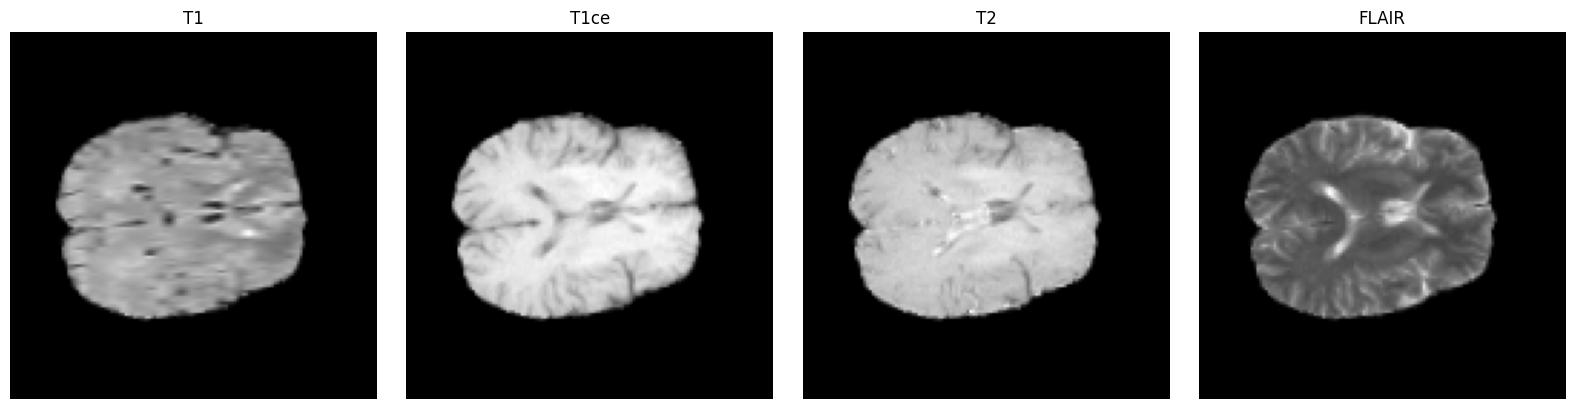

In [34]:

# =========================
# 6. Create DataLoader
# =========================
train_dataset = BraTSDataset("/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Test one batch
imgs, mask = next(iter(train_loader))
print("Batch MRI shape:", imgs.shape)  # [B, 4, H, W, D]
print("Batch Mask shape:", mask.shape)
# Visualise
plot_mri_modalities(imgs[0], slice_idx=64)  # visualize slice 64
